## Dataset

Link: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-2015-data-colored-resized?resource=download

In [1]:
import os
import pandas as pd

data_root = "dataset"
images_root = os.path.join("dataset", "colored_images", "colored_images")

assert os.path.exists(data_root)
assert os.path.exists(images_root) == True

Let's check the dataset class distribution and how many images are there in each class.

In [2]:
class_names = os.listdir(images_root)
class_names

['Proliferate_DR', 'Moderate', 'Mild', 'No_DR', 'Severe']

In [3]:
class_by_image_count = dict()
for class_name in class_names:
    file_list = os.listdir(
        os.path.join(images_root, class_name)
    )
    
    file_count = len(file_list)
    
    class_by_image_count[class_name] = file_count
    
class_by_image_count

{'Proliferate_DR': 708,
 'Moderate': 5292,
 'Mild': 2443,
 'No_DR': 25810,
 'Severe': 873}

The dataset looks imbalanced. More weights will go towards moderate just because of the higher count.

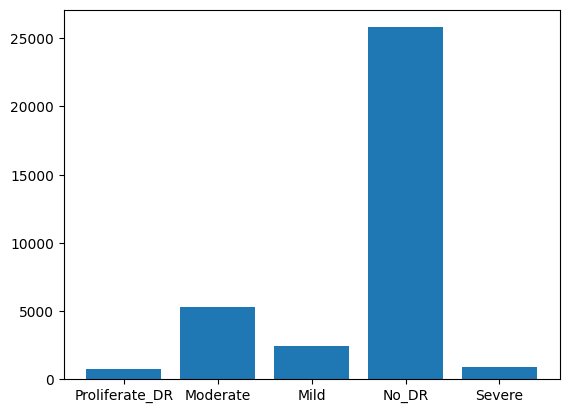

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(
    list(class_by_image_count.keys()),
    list(class_by_image_count.values()),
)
plt.show()

I don't see any other option than using a weight based loss function with this.

### Class Weights

In [5]:
class_weights = dict()

total_images = sum(list(class_by_image_count.values()))
for k, v in class_by_image_count.items():
    class_weights[k] = 1 - float(v / total_images)
    
class_weights 

{'Proliferate_DR': 0.9798439902066846,
 'Moderate': 0.8493423674770825,
 'Mild': 0.9304503786369072,
 'No_DR': 0.26521664863633776,
 'Severe': 0.975146615042988}

Now to look at the csvfile. 

In [6]:
df = pd.read_csv(os.path.join(data_root, "trainLabels.csv"))
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [7]:
set(df["level"].values)

{0, 1, 2, 3, 4}

Now which digit corresponds to which one? 
According to [this](https://www.kaggle.com/code/parisanahmadi/dl-diabet-retinopathy-detection2-73-acc-by-parisan/notebook), the level to class name mapping should be as follows:

In [8]:
label_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

That's label mapping taken care of (I hope it's the correct one or kaggle people are to blame :P ). Now to create the train, validation, test splits. 

### Splits

In [9]:
images = df["image"].values
labels = df["level"].values

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

# set seed to 0 for reproducibility
np.random.seed(0)

# 30% for testing
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3)
# 25% of the train set as validation
images_train, images_val, labels_train, labels_val = train_test_split(images_train, labels_train, test_size=0.25)

### Pytorch Dataset

The splits contain the image file names without extensions and labels (0 to 4). 

In [11]:
from typing import Tuple

import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, 
                 image_names: np.ndarray, 
                 labels: np.ndarray, 
                 grayscale_channels: int, # 0 means color
                 dataset_root: str=data_root, 
                 image_root_path: str=images_root,
                 label_dict: dict=label_dict) -> None:
        self.DATASET_ROOT = dataset_root
        self.IMAGES_ROOT_PATH = image_root_path
        
        self.label_dict = label_dict
        
        self.IMAGE_EXTENSION = ".png"
        self.image_file_names = image_names
        self.labels = labels
        
        # define transforms
        if grayscale_channels != 0:
            self._transforms = transforms.Compose([
                transforms.Grayscale(num_output_channels=grayscale_channels),
                transforms.ToTensor()
            ])
        else:
            self._transforms = transforms.Compose([
                transforms.ToTensor()
            ])
        

        
    def __len__(self) -> int:
        return len(self.image_file_names)
    
    def __getitem__(self, index) -> Tuple:
        image_name = self.image_file_names[index] + self.IMAGE_EXTENSION
        label = self.labels[index]
        
        image_path = os.path.join(
            self.IMAGES_ROOT_PATH,
            self.label_dict[label], # class name, e.g. Mild, Moderate etc.,
            image_name
        )
        
        image = Image.open(image_path)        
        
        # run transforms
        image = self._transforms(image)
        
        # convert label to tensor
        label = torch.tensor(label, dtype=torch.long)
        
        return (image, label)

In [12]:
GRAY = 0
train_set = DiabeticRetinopathyDataset(
    images_train, labels_train, GRAY)  # type: ignore
val_set = DiabeticRetinopathyDataset(
    images_val, labels_val, GRAY)  # type: ignore
test_set = DiabeticRetinopathyDataset(
    images_test, labels_test, GRAY)  # type: ignore

### Dataloaders

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

loader_args = {
    "batch_size": BATCH_SIZE,
    "pin_memory": True
}

train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(train_set, shuffle=False, **loader_args) # don't shuffle validation data
test_loader = DataLoader(train_set, shuffle=False, **loader_args)


## Pytorch model

In [14]:
import pytorch_lightning as pl
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchmetrics.functional import precision_recall, f1_score, accuracy


class Classifier(pl.LightningModule):
    def __init__(self, num_labels: int, learning_rate: float, class_weights: torch.Tensor, freeze: bool=True) -> None:
        super(Classifier, self).__init__()
        
        self.num_labels = num_labels
        self.learning_rate = learning_rate
        
        self.save_hyperparameters()
        
        # not frozen by default
        self.feature_model = resnet50(weights=ResNet50_Weights.DEFAULT, progress=True)
        if freeze:
            for p in self.feature_model.parameters():
                p.requires_grad = False
                
        final_layer_features = self.__find_n_features()
        
        # linear / dense layer
        self.dense = nn.Linear(final_layer_features, self.num_labels)
        self.relu = nn.ReLU()
        
        
        # softmax
        self.softmax = nn.Softmax(dim=1)
        
        # loss function
        self.loss_fn = nn.NLLLoss(weight=class_weights)
                
        
    # finds the number of dimensions of the last layer of resnet
    def __find_n_features(self):
        inp = torch.autograd.Variable(
            torch.rand(1, 3, 224, 224)
        )
        out_f = self.feature_model(inp)
        n_size = out_f.data.view(1, -1).size(1)
        return n_size
    
    def forward(self, image:torch.Tensor) -> torch.Tensor:
        features = self.feature_model(image)
        out = self.dense(features)
        out = self.relu(out)
        out = self.softmax(out)
        
        return out
    
    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_index) -> dict:
        image, label = batch
        
        logits = self(image)
        loss = self.loss_fn(logits, label)
        
        log = {
            "loss": loss
        }
        
        proba, idx = torch.max(logits, dim=-1)
        self.log("train_acc", accuracy(idx, label), prog_bar=True)
        self.log("train_f1", f1_score(idx, label), prog_bar=True)
        
        
        return log
    
    def validation_step(self, batch, batch_index) -> None:
        image, label = batch
        logits = self(image)
        loss = self.loss_fn(logits, label)
        
        proba, idx = torch.max(logits, dim=-1)
        self.log("val_acc", accuracy(idx, label), prog_bar=True)
        self.log("val_f1", f1_score(idx, label), prog_bar=True)
        
        self.log("validation_loss", loss, prog_bar=True)
        
    def test_step(self, batch, batch_index) -> None:
        image, label = batch
        logits = self(image)
        
        proba, idx = torch.max(logits, dim=-1)
        self.log("test_acc", accuracy(idx, label), prog_bar=True)
        self.log("test_f1", f1_score(idx, label), prog_bar=True)


In [15]:
from typing import List

lr = 2e-6
num_labels = 5

def get_label_weights(class_weights:dict, class_names:List[str]) -> torch.tensor:
    weights = torch.zeros(5)
    for idx, cname in enumerate(class_names):
        weights[idx] = class_weights[cname]
        
    return weights


class_weights_tensor = get_label_weights(class_weights, label_dict.values())

print(label_dict)
print(class_weights_tensor)

{0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
tensor([0.2652, 0.9305, 0.8493, 0.9751, 0.9798])


In [16]:
model = Classifier(num_labels, lr, class_weights_tensor)

Run a sample forward pass to check!

In [17]:
with torch.no_grad():
    sample = train_set[0]
    image, label = sample

    # add a batch dim
    # basically adds a batch size of 1
    image = image.unsqueeze(0)
    label = label.unsqueeze(0)
    out = model(image)
    
    print(out)
    
    print(F.nll_loss(out, label))


tensor([[0.1934, 0.2257, 0.1934, 0.1941, 0.1934]])
tensor(-0.1934)


## Trainer

In [18]:
epochs = 20

trainer = pl.Trainer(
    max_epochs=epochs,
    devices=1,
    accelerator="gpu",
    precision=16,
    log_every_n_steps=10,
    val_check_interval=100
)


trainer.fit(model, train_loader, val_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params
------------------------------------------
0 | feature_model | ResNet  | 25.6 M
1 | dense         | Linear  | 5.0 K 
2 | relu          | ReLU    | 0     
3 | softmax       | Softmax | 0     
4 | loss_fn       | NLLLoss | 0     
------------------------------------------
5.0 K     Trainable params
25.6 M    Non-trainable params
25.6 M    Total params
51.124    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/shawon/Projects/experiments/exp_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/shawon/Projects/experiments/exp_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Test

In [20]:
trainer.test(model, dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6297380924224854
         test_f1            0.6297380924224854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6297380924224854, 'test_f1': 0.6297380924224854}]